In [1]:
#Add packages
#These are my standard packages I load for almost every project
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import  shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import pickle
from sklearn.manifold import TSNE
import csv
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import time
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from functools import partial
import warnings
warnings.filterwarnings('ignore')

logPath = "./tb_logs"
n_class = 500
features = 2500



In [2]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [4]:
import os
os.getcwd()

'/Users/ak055384/Documents/HIMClaims/MDC'

In [5]:
os.chdir('/Users/ak055384/Documents/HIMClaims/MDC')

In [6]:
os.getcwd()

'/Users/ak055384/Documents/HIMClaims/MDC'

In [7]:
claims = pd.read_csv("DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv", sep=",", encoding = 'utf8')
claims.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Grouper(DRG)')

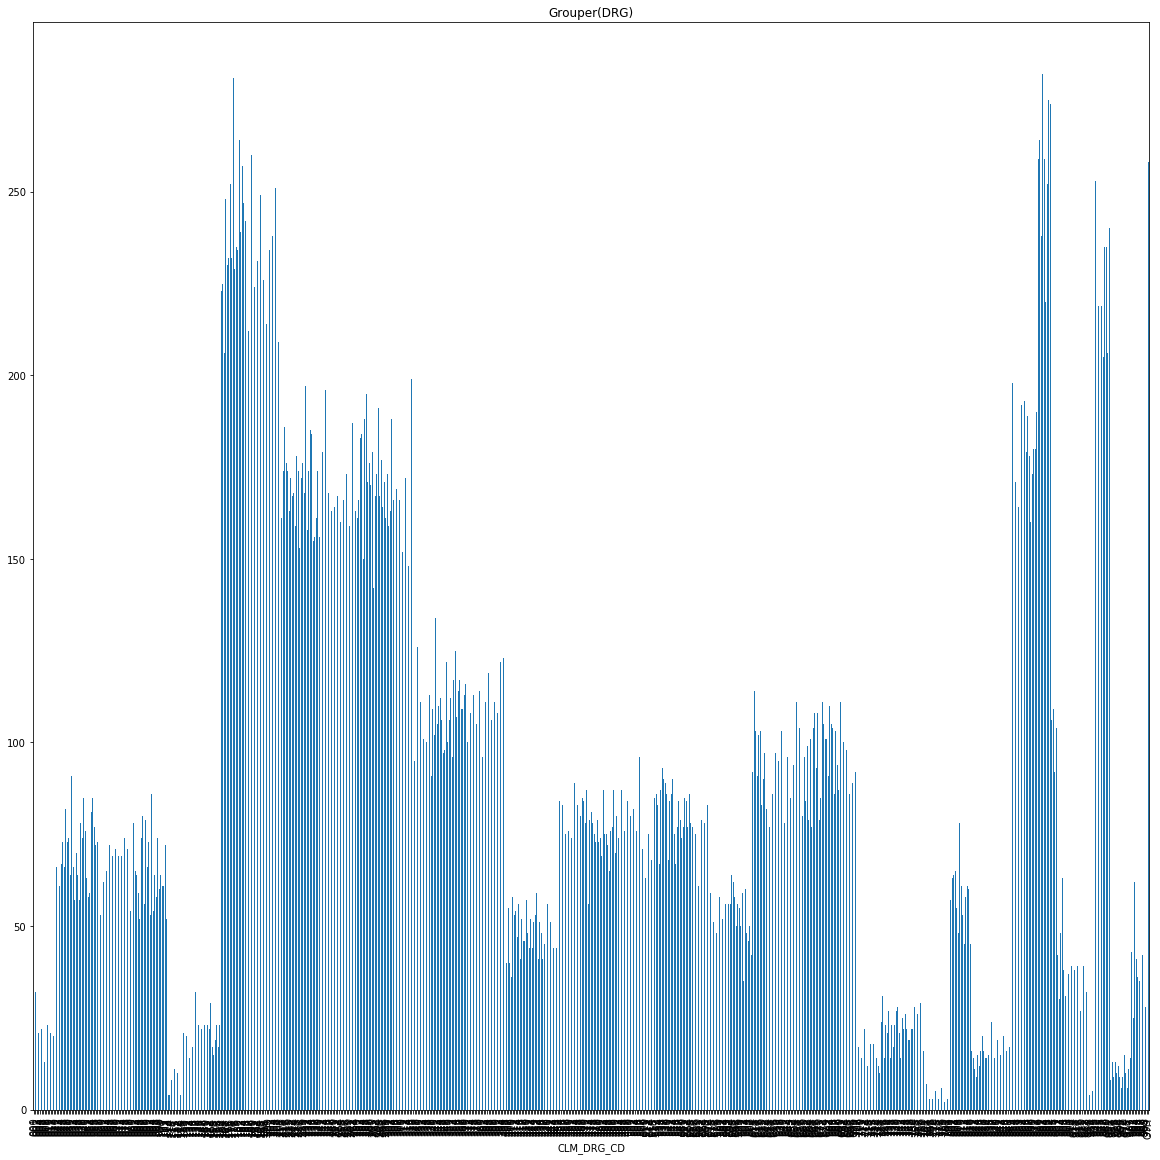

In [15]:
targetName = 'CLM_DRG_CD'
claimsAgg = claims.groupby(targetName)['CLM_ID'].aggregate(len)
claimsAgg.plot(kind='bar', grid=False, figsize=(20,20)).set_title('Grouper(DRG)')

In [9]:
summary = pd.read_csv("DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv", sep=",", encoding = 'utf8')
print(summary.columns)

Index(['DESYNPUF_ID', 'BENE_BIRTH_DT', 'BENE_DEATH_DT', 'BENE_SEX_IDENT_CD',
       'BENE_RACE_CD', 'BENE_ESRD_IND', 'SP_STATE_CODE', 'BENE_COUNTY_CD',
       'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'],
      dtype='object')


In [10]:
claimsSummary = pd.merge(claims, summary, how='inner', on='DESYNPUF_ID')
claimsSummary.shape

(66773, 112)

In [16]:
drg = pd.read_csv("Drg.csv")
drg['CLM_DRG_CD'] = drg['DRG_CD'].astype(str)
drg.head(5)

,DRG_CD,MDC,Description,Type,MDC_Des,CLM_DRG_CD
0,1,PRE-MDC,HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...,Surgical,Pre-MDC,1
1,2,PRE-MDC,HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...,Surgical,Pre-MDC,2
2,3,PRE-MDC,"ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MO...",Surgical,Pre-MDC,3
3,4,PRE-MDC,"TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NE...",Surgical,Pre-MDC,4
4,5,PRE-MDC,LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,Surgical,Pre-MDC,5


In [17]:
joinClaims = pd.merge(claimsSummary, drg, how='left', on='CLM_DRG_CD')
joinClaims = joinClaims[joinClaims['MDC'].notnull()]
targetName = 'MDC'
targetSeries = joinClaims[targetName]
del joinClaims[targetName]
joinClaims.insert(0, targetName, targetSeries)
joinClaims.shape

(59642, 117)

In [18]:
joinClaims.head()

,MDC,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,...,MEDREIMB_OP,BENRES_OP,PPPYMT_OP,MEDREIMB_CAR,BENRES_CAR,PPPYMT_CAR,DRG_CD,Description,Type,MDC_Des
0,MDC-05,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,...,50.0,10.0,0.0,0.0,0.0,0.0,217.0,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W ...,Surgical,Diseases and Disorders of the Circulatory System
1,MDC-04,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,...,0.0,0.0,0.0,700.0,240.0,0.0,201.0,PNEUMOTHORAX W/O CC/MCC,Medical,"Diseases and Disorders of the Ear, Nose, Mouth..."
3,MDC-19,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,...,0.0,0.0,0.0,700.0,240.0,0.0,883.0,DISORDERS OF PERSONALITY & IMPULSE CONTROL,Medical,Mental Diseases and Disorders
4,UNGROUPABLE,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,...,0.0,0.0,0.0,700.0,240.0,0.0,983.0,EXTENSIVE O.R. PROCEDURE UNRELATED TO PRINCIPA...,Surgical,MDC Category Missing
5,MDC-04,00052705243EA128,196991176971757,1,20080912.0,20080912.0,1401HG,14000.0,0.0,6.132011e+09,...,4240.0,3130.0,0.0,6740.0,2130.0,1200.0,201.0,PNEUMOTHORAX W/O CC/MCC,Medical,"Diseases and Disorders of the Ear, Nose, Mouth..."


In [19]:
interestingColumns = ['MDC', 'ADMTNG_ICD9_DGNS_CD','ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
       'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6',
       'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
       'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
       'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_BIRTH_DT','SP_STATE_CODE']
dgnColumns = ['ADMTNG_ICD9_DGNS_CD', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
       'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6',
       'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10']
prcdrColumns = [ 'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
       'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6']
demoColumns = ['BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_BIRTH_DT','SP_STATE_CODE']
claims_subset_df = joinClaims[dgnColumns + prcdrColumns]
claims_subset_df = claims_subset_df.reset_index(drop=True)
claims_subset_df.shape

(59642, 17)

In [20]:
claims_subset_df2 = joinClaims[demoColumns]
claims_subset_df2 = claims_subset_df2.reset_index(drop=True)
claims_subset_df2.shape

(59642, 4)

Text(0.5, 1.0, 'MDC')

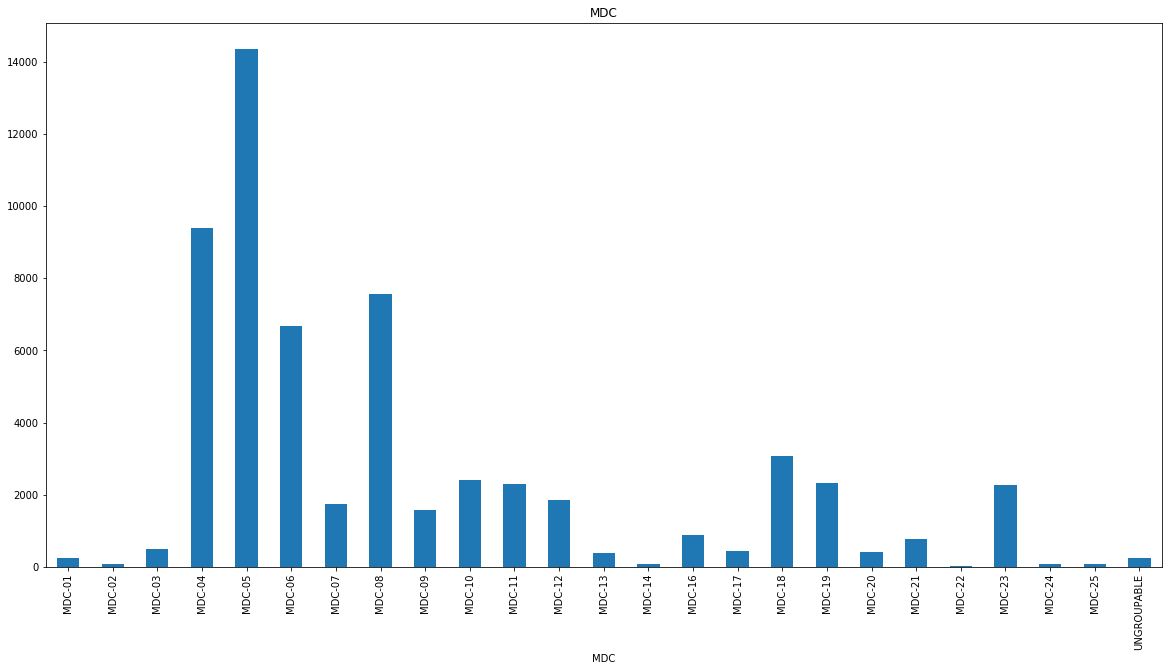

In [21]:
claimsAgg = joinClaims.groupby(targetName)['CLM_ID'].aggregate(len)
claimsAgg.plot(kind='bar', grid=False, figsize=(20,10)).set_title('MDC')

In [22]:
claims_subset_df['ADMTNG_ICD9_DGNS_CD'] = claims_subset_df['ADMTNG_ICD9_DGNS_CD'].astype(str)
claims_subset_df['ADMTNG_ICD9_DGNS_CD'] = claims_subset_df['ADMTNG_ICD9_DGNS_CD'].str.strip().str.replace('.', '')
claims_subset_df['ADMTNG_ICD9_DGNS_CD'] = claims_subset_df['ADMTNG_ICD9_DGNS_CD'].str.strip().str.replace('NaN', '0')
claims_subset_df['ADMTNG_ICD9_DGNS_CD'] = claims_subset_df['ADMTNG_ICD9_DGNS_CD'].str.strip().str.replace('nan', '0')
for j in range(1,11):
    claims_subset_df['ICD9_DGNS_CD_' + str(j)] = claims_subset_df['ICD9_DGNS_CD_' + str(j)].astype(str)
    claims_subset_df['ICD9_DGNS_CD_' + str(j)] = claims_subset_df['ICD9_DGNS_CD_' + str(j)].str.strip().str.replace('.', '')
    claims_subset_df['ICD9_DGNS_CD_' + str(j)] = claims_subset_df['ICD9_DGNS_CD_' + str(j)].str.strip().str.replace('NaN', '0')
    claims_subset_df['ICD9_DGNS_CD_' + str(j)] = claims_subset_df['ICD9_DGNS_CD_' + str(j)].str.strip().str.replace('nan', '0')
for j in range(1,7):
    claims_subset_df['ICD9_PRCDR_CD_' + str(j)] = claims_subset_df['ICD9_PRCDR_CD_' + str(j)].astype(str)
    claims_subset_df['ICD9_PRCDR_CD_' + str(j)] = claims_subset_df['ICD9_PRCDR_CD_' + str(j)].str.strip().str.replace('.', '')
    claims_subset_df['ICD9_PRCDR_CD_' + str(j)] = claims_subset_df['ICD9_PRCDR_CD_' + str(j)].str.strip().str.replace('NaN', '0')
    claims_subset_df['ICD9_PRCDR_CD_' + str(j)] = claims_subset_df['ICD9_PRCDR_CD_' + str(j)].str.strip().str.replace('nan', '0')

In [34]:
start_time = time.clock()
cat = CategoricalEncoder()
train_df = cat.fit_transform(claims_subset_df['ADMTNG_ICD9_DGNS_CD'].values.reshape(-1,1))
train_df_c = pd.DataFrame(train_df.toarray(), columns=cat.categories_)
print("Time to run", time.clock() - start_time, "seconds")

Time to run 2.6722090000000094 seconds


In [35]:
train_df_c.shape

(59642, 2076)

In [36]:
start_time = time.clock()
cat = CategoricalEncoder()
train_df = cat.fit_transform(claims_subset_df[interestingColumns[2]].values.reshape(-1,1))
train_df_c = train_df_c.append(pd.DataFrame(train_df.toarray(), columns=cat.categories_))
train_df_c.fillna(0.0)
print(train_df_c.shape)
print("Time to run", time.clock() - start_time, "seconds")

(119284, 2907)
Time to run 56.68931999999998 seconds


In [41]:
train_df_c.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59632, 59633, 59634, 59635, 59636, 59637, 59638, 59639, 59640,
            59641],
           dtype='int64', length=119284)

In [42]:
train_df_c = train_df_c.groupby(train_df_c.index).sum()

In [44]:
train_df_c.describe()

,0,0030,0031,0039,0049,0059,0071,00842,00843,00845,...,V652,V660,V702,V7109,V714,V717,V7189,V719,V7283,V7284
count,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,...,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000,59642.000000
mean,0.007243,0.000134,0.000017,0.000017,0.000034,0.000117,0.000017,0.000034,0.000084,0.006388,...,0.000017,0.000017,0.000017,0.000017,0.000134,0.000084,0.000084,0.000034,0.000034,0.000034
std,0.084799,0.011581,0.004095,0.004095,0.005791,0.010833,0.004095,0.005791,0.009156,0.089014,...,0.004095,0.004095,0.004095,0.004095,0.011581,0.009156,0.009156,0.005791,0.005791,0.005791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
for col in interestingColumns[2:18]:   
    j=j+1 
    cat = CategoricalEncoder()
    train_df = cat.fit_transform(claims_subset_df[col].values.reshape(-1,1))
    train_df_c = train_df_c.append(pd.DataFrame(train_df.toarray(), columns=cat.categories_))
    train_df_c = train_df_c.fillna(0.0)
    train_df_c = train_df_c.groupby(train_df_c.index).sum()
    print(train_df_c.shape)
    print("Time to run", time.clock() - start_time, "seconds")

(59642, 2907)
Time to run 32.94295012492274 seconds
(59642, 3962)
Time to run 73.12151242412034 seconds
(59642, 4339)
Time to run 120.19402689208768 seconds
(59642, 4602)
Time to run 170.85325457996547 seconds
(59642, 4797)
Time to run 227.5681921072693 seconds
(59642, 4952)
Time to run 288.18228147394103 seconds
(59642, 5077)
Time to run 345.8508811045911 seconds
(59642, 5165)
Time to run 404.5661807322583 seconds
(59642, 5241)
Time to run 457.7293588633598 seconds
(59642, 5251)
Time to run 501.28281359911523 seconds
(59642, 6327)
Time to run 548.3857905625091 seconds
(59642, 6376)
Time to run 611.6864482711878 seconds
(59642, 6408)
Time to run 671.8269669997813 seconds
(59642, 6423)
Time to run 729.1628220720372 seconds
(59642, 6434)
Time to run 787.6450514020156 seconds
(59642, 6443)
Time to run 841.0941143776499 seconds


In [15]:
train_df_new = pd.concat([train_df_c,claims_subset_df2 ], axis=1)
train_df_new.shape

(59642, 6447)

In [17]:
y = targetSeries
X = train_df_new
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(41749, 6447)
(41749,)
(17893, 6447)
(17893,)


In [18]:
from sklearn import tree 
clf_dt = tree.DecisionTreeClassifier()
print(clf_dt)
clf_dt = clf_dt.fit(X_train, y_train)
dt_expected = y_test
dt_predicted = clf_dt.predict(X_test)
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
accuracy: 0.6463980327502376
             precision    recall  f1-score   support

     MDC-01       0.16      0.12      0.14        85
     MDC-02       0.06      0.04      0.05        25
     MDC-03       0.28      0.24      0.26       156
     MDC-04       0.72      0.75      0.73      2816
     MDC-05       0.73      0.78      0.75      4340
     MDC-06       0.61      0.63      0.62      1987
     MDC-07       0.62      0.52      0.57       545
     MDC-08       0.75      0.75      0.75      2227
     MDC-09       0.53      0.50      0.51       509
     MDC-10       0.40      0.39      0.40       718
     MDC-11       0.32      0.31     

In [19]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(fit_prior = False)
print(clf_nb)
clf_nb.fit(X_train, y_train)
dt_expected = y_test
dt_predicted = clf_nb.predict(X_test)
print(clf_nb.score(X_test, y_test))
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)
0.7913709271782261
accuracy: 0.7913709271782261
             precision    recall  f1-score   support

     MDC-01       0.00      0.00      0.00        85
     MDC-02       0.00      0.00      0.00        25
     MDC-03       1.00      0.01      0.01       156
     MDC-04       0.79      0.91      0.85      2816
     MDC-05       0.90      0.86      0.88      4340
     MDC-06       0.81      0.93      0.87      1987
     MDC-07       0.92      0.86      0.89       545
     MDC-08       0.91      0.91      0.91      2227
     MDC-09       0.82      0.73      0.77       509
     MDC-10       0.58      0.68      0.63       718
     MDC-11       0.41      0.49      0.45       679
     MDC-12       0.35      0.17      0.22       533
     MDC-13       1.00      0.07      0.13       125
     MDC-14       0.00      0.00      0.00        17
     MDC-16       0.72      0.24      0.35       246
     MDC-17       1.00      0.22      0.36 

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_features= 'auto', oob_score = True)
print(clf_rf)
clf_rf.fit(X_train, y_train)
dt_expected = y_test
dt_predicted = clf_rf.predict(X_test)
print(clf_rf.score(X_test, y_test))
# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(dt_expected, dt_predicted)))
print(metrics.classification_report(dt_expected, dt_predicted))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
0.7243614821438551
accuracy: 0.7243614821438551
             precision    recall  f1-score   support

     MDC-01       0.33      0.07      0.12        85
     MDC-02       0.50      0.04      0.07        25
     MDC-03       0.49      0.23      0.31       156
     MDC-04       0.69      0.88      0.77      2816
     MDC-05       0.71      0.87      0.79      4340
     MDC-06       0.68      0.79      0.73      1987
     MDC-07       0.84      0.61      0.70       545
     MDC-08       0.85      0.83      0.84      2227
     MDC-09       0.76      0.54      0.63       509
     MDC-10  